In [301]:
import xml.etree.ElementTree as ET
import re
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

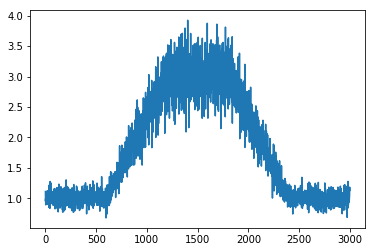

In [302]:
## Tuning demand

def get_veh_sec(x, demand,high, nominal,total_time):
    
    factor = 10

    if demand == "rush":
        part = total_time/5
        if x < part:
            return np.random.normal(nominal, nominal/factor)
        if x < 2*part:
            aux = (nominal-high)/(-part)*x + nominal + (nominal-high)
            return np.random.normal(aux, aux/factor)
        if x < 3*part:
            return np.random.normal(high, high/factor)
        if x < 4*part:
            aux = -(high-nominal)/(part)*x + high+(high-nominal)*3
            return np.random.normal(aux, aux/factor)
        else:
            return np.random.normal(nominal, nominal/factor)
    else:
        return 1
x = []    
for i in range(3000):
    x.append(get_veh_sec(i, "rush", 3, 1, 3000))
    
plt.plot(x)

In [272]:
path = "./logs/Check_output/run_1"

def plot_evaluation(path, labels = None ):
         
    if not labels: labels = re.findall(r'tripinfo_\w+\.xml',' '.join(os.listdir(path)))

    eval_results = pd.DataFrame()
    labels
    for eval_label in labels:

        label = re.findall(r'_(\w+).',eval_label)[0]   
        tree = ET.parse(os.path.join(output_dir,eval_label))
        root = tree.getroot()


        df = {"depart" : [],
              "veh_id" : [],
              "duration" : [],
              "arrival" : [],
              "emissions" : []}

        for veh in root:
            df["veh_id"].append(veh.get("id"))
            df["depart"].append(float(veh.get("depart")))
            df["duration"].append(float(veh.get("duration")))
            df["arrival"].append(float(veh.get("arrival")))
            df["emissions"].append(float(veh[0].get("CO2_abs")))

        data = pd.DataFrame(df)

        bins = np.arange(start = 0, stop = data.arrival.max(), step = 30)
        data["interval"] = pd.cut(data.depart, bins= bins, labels = range(len(bins)-1))
        agg_data = data.groupby(data.interval)[["veh_id","duration","emissions"]].agg({"veh_id": lambda x: len(set(x)),'duration': np.sum,'emissions': np.mean})
        label = "fixed" if re.findall(r'fixed',label) else "RL"
        agg_data["label"] = label
        agg_data.reset_index(level=0, inplace=True)
        agg_data["interval"]=agg_data.interval.astype(int)*30#/agg_data.interval.max()


        eval_results = pd.concat([eval_results,agg_data], ignore_index=True)

    fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize = (12,7))

    sns.lineplot(x = 'interval',    
                 y = 'veh_id', 
                 ci = 'sd', 
                 data = eval_results,
                 legend = False,
                 ax = axes[0]).set_title("Demand");

    axes[0].set_ylabel("Number of vehicles")

    sns.lineplot(x = 'interval',    
                 y = 'duration', 
                 ci = 'sd', 
                 hue = 'label', 
                 data = eval_results,
                 legend = 'brief',
                 ax = axes[1]).set_title("Delay");

    axes[1].set_ylabel("[s]")
    
    #fig.show()

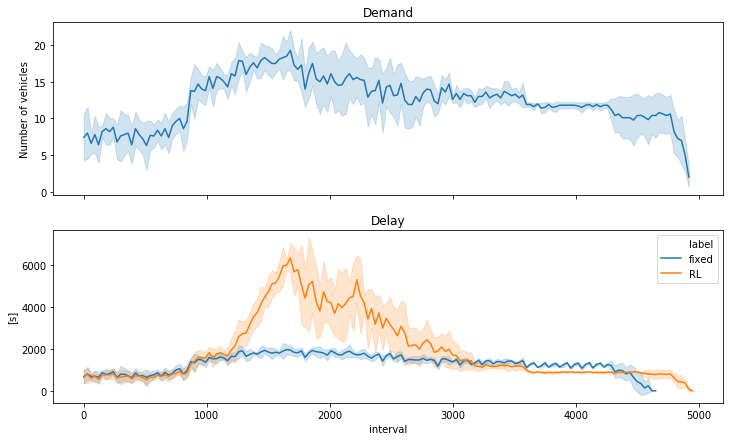

In [273]:
plot_evaluation(path)

In [305]:
res = pd.DataFrame()

evalu = []
with open('../Experiment_results/Big_Complex_Balanced_Negative_Reward/GS_results.json') as file:
    data = json.load(file)
    for run in data['results']:
        #train_data = pd.DataFrame(run["train_data"])
        #train_data["run"] = run["run"]
        #res = pd.concat([res,train_data], ignore_index= True)
        
        evalu.append({"run" :run["run"],
         "unfinished": run['eval_delay']['unfinished_runs'],             
         "RL" : np.mean(run["eval_delay"]["episode_mean_delays"]),
        "fixed" :np.mean(run["eval_delay"]["episode_mean_delays_fixed"])})
        

res = pd.DataFrame(evalu)
        
#         evaluate_data = pd.DataFrame(run["eval_delay"])
#         evaluate_data["run"] = run["run"]
#         res = pd.concat([res,evaluate_data], ignore_index= True)

In [306]:
# Big complex
res.sort_values("RL")

,RL,fixed,run,unfinished
7,-1.000000,599.026275,1,5
4,91.180679,603.552406,5,1
6,95.304829,589.192792,7,1
5,104.234853,582.788876,3,0
8,105.002680,599.461223,10,0
3,108.431170,635.295574,2,0
0,108.965198,627.958029,8,0
1,109.581748,587.376834,6,0
2,109.586833,608.590641,4,0
11,109.655431,588.125685,12,0


In [304]:
# COmplex
res.sort_values("RL")

,RL,fixed,run,unfinished
7,-1.000000,616.474768,3,5
6,43.475037,592.806666,1,3
5,68.986627,592.407573,5,2
2,107.127519,588.772348,4,0
0,107.365205,572.176670,8,0
1,107.664313,585.033362,6,0
4,107.725437,586.461372,2,0
11,108.077797,606.273155,12,0
8,109.055944,582.837730,10,0
10,110.734022,586.029543,11,0


Text(17.200000000000003, 0.5, '[s]')

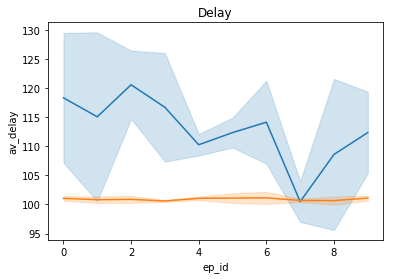

In [275]:
#fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize = (12,7))

sns.lineplot(x = 'ep_id',    
             y = 'av_delay', 
             ci = 'sd', 
             data = res,
             hue = 'label',
             legend = False,
             ).set_title("Delay");

axes[0].set_ylabel("[s]")


# sns.lineplot(x = 'ep_id',    
#              y = 'total_reward', 
#              ci = 'sd', 
#              hue= 'label',
#              data = res,
#              legend = 'brief',
#              ax = axes[1]).set_title("Reward");

# axes[1].set_ylabel("Reward")